In [1]:
from __future__ import print_function, division, absolute_import
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc

#plt.style.use('dark_background')
rc('font', size=18)

In [3]:
from skreflectometry.mode_O import refraction_index_O, refractive_matrix_O, cutoff_freq_O, abel_inversion
from skreflectometry.mode_X import refraction_index_X, refractive_matrix_X, cutoff_freq_X
from skreflectometry.physics import cyclotron_frequency, plasma_frequency, cyclotron_field, upper_hybrid_frequency, plasma_density
from skreflectometry.data_generation import density_profile, density_add_bump, magnetic_field_profile
from skreflectometry.reflectometry_sim import time_delay, phase_delay

ImportError: cannot import name time_delay

In [4]:
B = 2
dens = 1e19
f = np.linspace(.5e10, 1e11, 1000)

n_O_sq = refraction_index_O(f, dens, squared=True)
n_X_sq = refraction_index_X(f, dens, B, squared=True)

fpe = plasma_frequency(dens)
fce = cyclotron_frequency(B)
fH = upper_hybrid_frequency(dens, B)

fL, fR = cutoff_freq_X(dens, B)

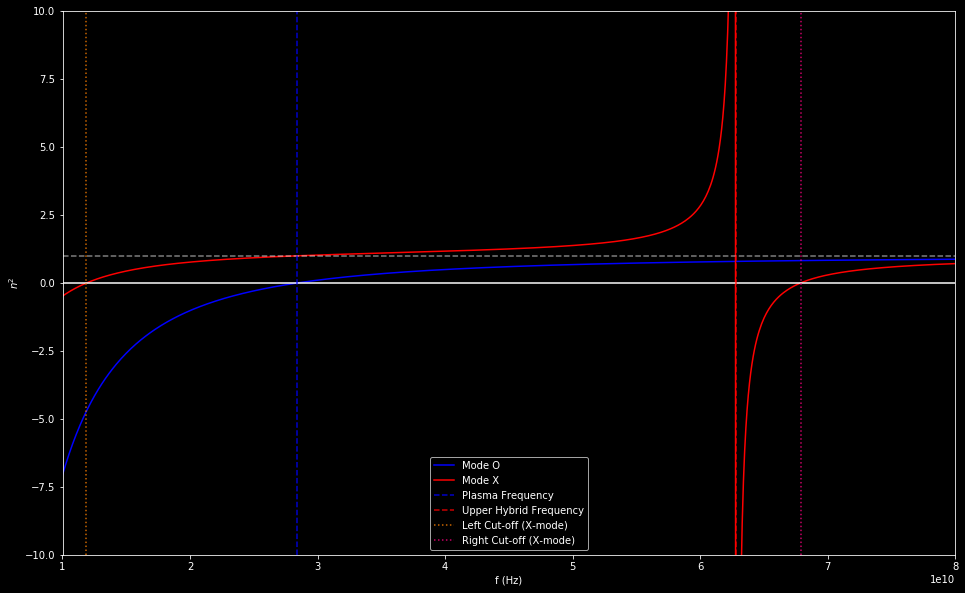

In [5]:
plt.figure(figsize=(16,10))

plt.plot(f, n_O_sq, 'b-', label='Mode O')
plt.plot(f, n_X_sq, 'r-', label='Mode X')

plt.axhline(0)
plt.axhline(1, ls='--', alpha=0.5)

plt.axvline(fpe, color='b', alpha=0.8, ls='--', label='Plasma Frequency')
plt.axvline(fH, color='r', alpha=0.8, ls='--', label='Upper Hybrid Frequency')
plt.axvline(fL, color=(1, 0.5, 0), alpha=0.8, ls=':', label='Left Cut-off (X-mode)')
plt.axvline(fR, color=(1, 0, 0.5), alpha=0.8, ls=':', label='Right Cut-off (X-mode)')

plt.legend()
plt.ylim(-10, 10)
plt.xlim(.1e11, .8e11)

plt.ylabel('$n^2$')
plt.xlabel('f (Hz)')

plt.show()

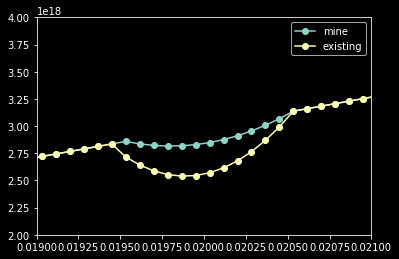

In [6]:
rs, n1 = density_profile(radius_arr=np.linspace(2.15, 2.1, 600), m=30, n=3, dens_central=1e19, r_vacuum=0.002)
n2 = density_profile(radius_arr=np.linspace(2.15, 2.1, 600), m=30, n=3, dens_central=1e19, r_vacuum=0.002)
rs = rs[0] - rs

n1 = density_add_bump(rs, n1, bump_pos=0.02, bump_size=0.001, bump_height=.95)
n2 = density_add_bump(rs, n1, bump_pos=0.02, bump_size=0.001, bump_height=.95, bug=True)

plt.plot(rs, n1, '-o', label='mine')
plt.plot(rs, n2, '-o', label='existing')

plt.xlim(0.019, 0.021)
plt.ylim(0.2e19, 0.4e19)

plt.legend()

plt.show()

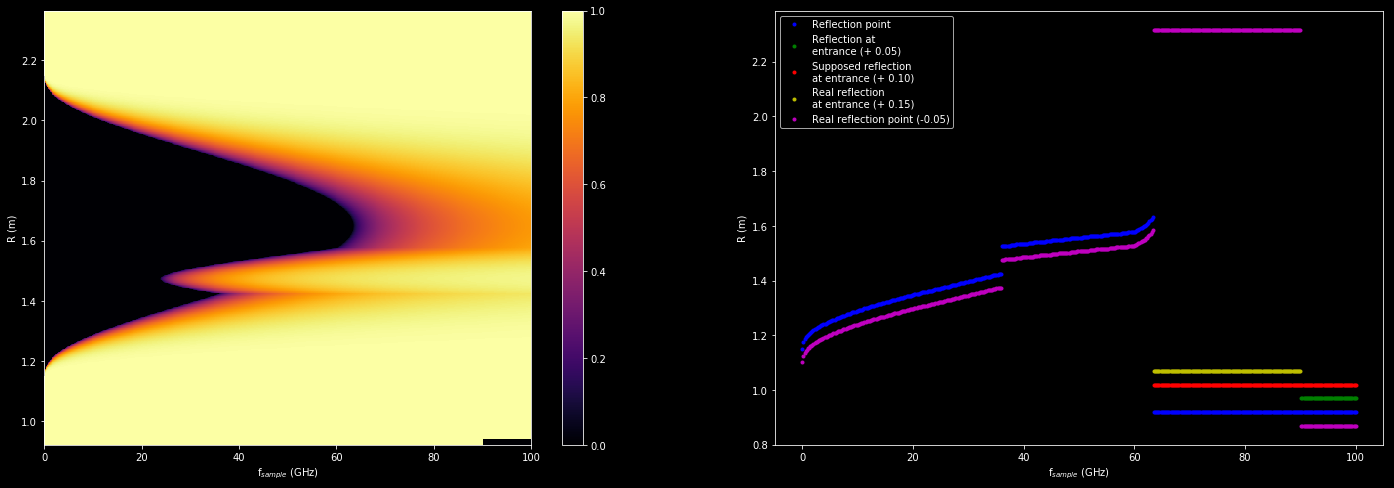

In [20]:
radius_arr, dens_prof = density_profile(n_points=600)
dens_prof = density_add_bump(radius_arr, dens_prof, bump_pos=1.5, bump_size=0.15, bump_height=0.3)
fs_O = np.linspace(1, 1e11, 500)
n_index_O_test = refractive_matrix_O(dens_prof, fs_O)

n_index_O_test[450:500, 0:10] = 0

p0 = np.argmax(n_index_O_test <= 0, axis=1)
p1 = n_index_O_test[:, 0] <= 0
p2 = p0 == 0
p3 = p1 ^ p2
p4 = np.copy(p0)
p4[p3] = n_index_O_test.shape[1] - 1

min_d = radius_arr.min()

plt.figure(figsize=(24,8))

plt.subplot(1, 2, 1)

plt.pcolormesh(fs_O/1e9, radius_arr, n_index_O_test.T, cmap='inferno')
plt.colorbar()

plt.xlabel('f$_{sample}$ (GHz)')
plt.ylabel('R (m)')

plt.subplot(1, 2, 2)

plt.plot(fs_O/1e9, radius_arr[p0], 'b.', label='Reflection point')
plt.plot(fs_O[p1]/1e9, min_d * np.ones(len(fs_O[p1])) + 0.05, 'g.', label='Reflection at \nentrance (+ 0.05)')
plt.plot(fs_O[p2]/1e9, min_d * np.ones(len(fs_O[p2])) + 0.10, 'r.', label='Supposed reflection \nat entrance (+ 0.10)')
plt.plot(fs_O[p3]/1e9, min_d * np.ones(len(fs_O[p3])) + 0.15, 'y.', label='Real reflection \nat entrance (+ 0.15)')
plt.plot(fs_O/1e9, radius_arr[p4] - 0.05, 'm.', label='Real reflection point (-0.05)')

plt.xlabel('f$_{sample}$ (GHz)')
plt.ylabel('R (m)')

plt.legend()

plt.show()

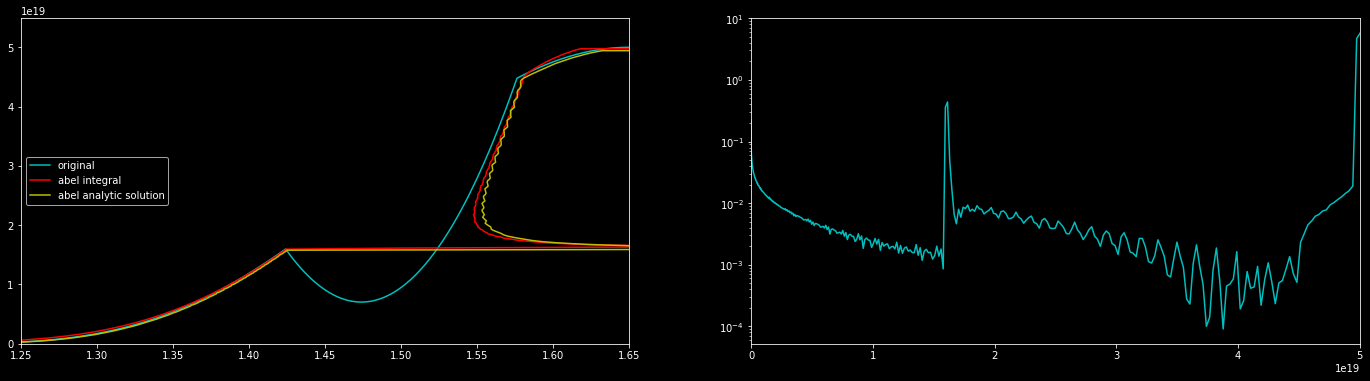

In [22]:
n_index_O = refractive_matrix_O(dens_prof, fs_O)
phi_O = phase_delay(fs_O, radius_arr, n_index_O, reflect_at_wall=True)
delta_t_O = time_delay(fs_O, phi_O)

radius_calc, dens_arr_to_calc = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0]+.04, other_method=False)
radius_calc_other, dens_arr_to_calc_other = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0], other_method=True)

plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)

plt.plot(radius_arr, dens_prof, 'c-', label='original')
plt.plot(radius_calc, dens_arr_to_calc, 'r-', label='abel integral')
plt.plot(radius_calc_other, dens_arr_to_calc_other, 'y-', label="abel analytic solution")

plt.xlim(1.25, 1.65)
plt.ylim(0, 5.5e19)

plt.legend(loc='center left')

plt.subplot(1, 2, 2)

plt.semilogy(dens_arr_to_calc[1:], np.abs(radius_calc[1:] - radius_calc_other[1:]), 'c-',)

plt.xlim(0, 5e19)

plt.show()

In [14]:
a = np.hstack((np.eye(3), np.zeros((3,3))))
print(a)
print(a[:, ::-1])

[[ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.]]
